In [1]:
import requests
import csv
import pandas as pd
import json
import os
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import re
import datetime

In [2]:
#  	https://data.ca.gov/datastore/odata3.0/d599c3d3-87af-4e8c-8694-9c01f49e3d93 2024
#   https://data.ca.gov/datastore/odata3.0/9aa5b4c5-252c-4d68-b1be-ffe19a2f1d26 2023
#   https://data.ca.gov/datastore/odata3.0/1856386b-a196-4e7c-be81-44174e29ad50 2022
#   https://data.ca.gov/datastore/odata3.0/888bbb6c-09b4-469c-82e6-1b2a47439736 2021
#   https://data.ca.gov/datastore/odata3.0/4254a06d-9937-4083-9441-65597dd267e8 2020
#   https://data.ca.gov/datastore/odata3.0/d304108a-06c1-462f-a144-981dd0109900 2019
#   https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code/resource/8d166753-2a2c-45f1-8529-2a7fc93f3ff5

#   https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code
resource_ids = {2024:'d599c3d3-87af-4e8c-8694-9c01f49e3d93',2023:'9aa5b4c5-252c-4d68-b1be-ffe19a2f1d26',2022:'1856386b-a196-4e7c-be81-44174e29ad50',
                2021:'888bbb6c-09b4-469c-82e6-1b2a47439736',2020:'4254a06d-9937-4083-9441-65597dd267e8',2019:'d304108a-06c1-462f-a144-981dd0109900'}

In [3]:
url = 'https://data.ca.gov/api/3/action/datastore_search?limit=10&resource_id=d599c3d3-87af-4e8c-8694-9c01f49e3d93'
with requests.get(url) as response:
        data = response.json()

In [5]:
def get_dataset(resource_id, limit=10000):

    #gets all entries from given resource id

    url_template_base = 'https://data.ca.gov'
    url_template = f'https://data.ca.gov/api/3/action/datastore_search?limit={limit}&resource_id='

    d = []
    rows = 0
    next = False
    nextkey = ''
    url = url_template + resource_id

    with requests.get(url) as response:
        data = response.json()
        rows = rows + len(data['result']['records'])
        d.append(data)
        print(rows, 'rows collected')

    if data['result']['_links']['next'] != None:
        next = True
        nextkey = url_template_base + data['result']['_links']['next']

    while next:

        with requests.get(nextkey) as response:
            data = response.json()
            rows = rows + len(data['result']['records'])
            d.append(data)

        if len(data['result']['records']) < limit:
            print(rows, 'rows collected total')
            next = False
        else:
            print(rows, 'rows collected')
            nextkey = url_template_base+data['result']['_links']['next']
    return d
    


def format_dataset_list(d):
    
    #formats get_dataset output to list format

    new_d = []
    for i in range(len(d)):
        data = d[i]['result']['records']
        new_d = new_d + data
    return {'results':new_d}



def dataset_to_df(d):
    ret = pd.DataFrame(d['results'])
    ret['Vehicles'] = ret['Vehicles'].astype('int')
    ret.columns = ['year_id', 'date', 'zipcode', 'modelyr', 'fuel', 'make', 'duty',
       'num_vehicles']
    ret['date'] = pd.to_datetime(ret['date'])
    return ret



def pipeline(resource_ids,limit = 50000, path='datasets/vehicle_fuel_types/', save_output=False):
    ret_list = []
    for key in resource_ids:
        print(f'working year {key}, resource_id {resource_ids[key]}')
        dataset = get_dataset(resource_ids[key], limit)
        d_list = format_dataset_list(dataset)
        df = dataset_to_df(d_list)
        if save_output:
            df.to_csv(f'{path}{key}_vehicle_fuel_types.csv')
            print(f'{key} dataset saved to {path}{key}_vehicle_fuel_types.csv')
        ret_list.append(df)
        print(f'year {key} idx={len(ret_list)-1} in ret\n')
    return ret_list



In [6]:
veh_dfs = pipeline(resource_ids,save_output=True)

working year 2024, resource_id d599c3d3-87af-4e8c-8694-9c01f49e3d93
50000 rows collected
100000 rows collected
150000 rows collected
200000 rows collected
250000 rows collected
300000 rows collected
350000 rows collected
400000 rows collected
450000 rows collected
499623 rows collected total
2024 dataset saved to datasets/vehicle_fuel_types/2024_vehicle_fuel_types.csv
year 2024 idx=0 in ret

working year 2023, resource_id 9aa5b4c5-252c-4d68-b1be-ffe19a2f1d26
50000 rows collected
100000 rows collected
150000 rows collected
200000 rows collected
250000 rows collected
300000 rows collected
350000 rows collected
400000 rows collected
450000 rows collected
500000 rows collected
550000 rows collected
600000 rows collected
650000 rows collected
700000 rows collected
750000 rows collected
767054 rows collected total
2023 dataset saved to datasets/vehicle_fuel_types/2023_vehicle_fuel_types.csv
year 2023 idx=1 in ret

working year 2022, resource_id 1856386b-a196-4e7c-be81-44174e29ad50
50000 rows

In [7]:
df = pd.concat(veh_dfs)
_24 = veh_dfs[0]
_23 = veh_dfs[1]
_22 = veh_dfs[2]
_21 = veh_dfs[3]
_20 = veh_dfs[4]
_19 = veh_dfs[5]

In [8]:
fuels = df.fuel.unique()

fuels
def get_classes(df):
    fuels = df.fuel.unique()
    makes = df.make.unique()
    duties = df.duty.unique()
    return fuels,makes,duties

In [22]:
fuels,makes,duties = get_classes(_24)

(1.0, 680283.0)

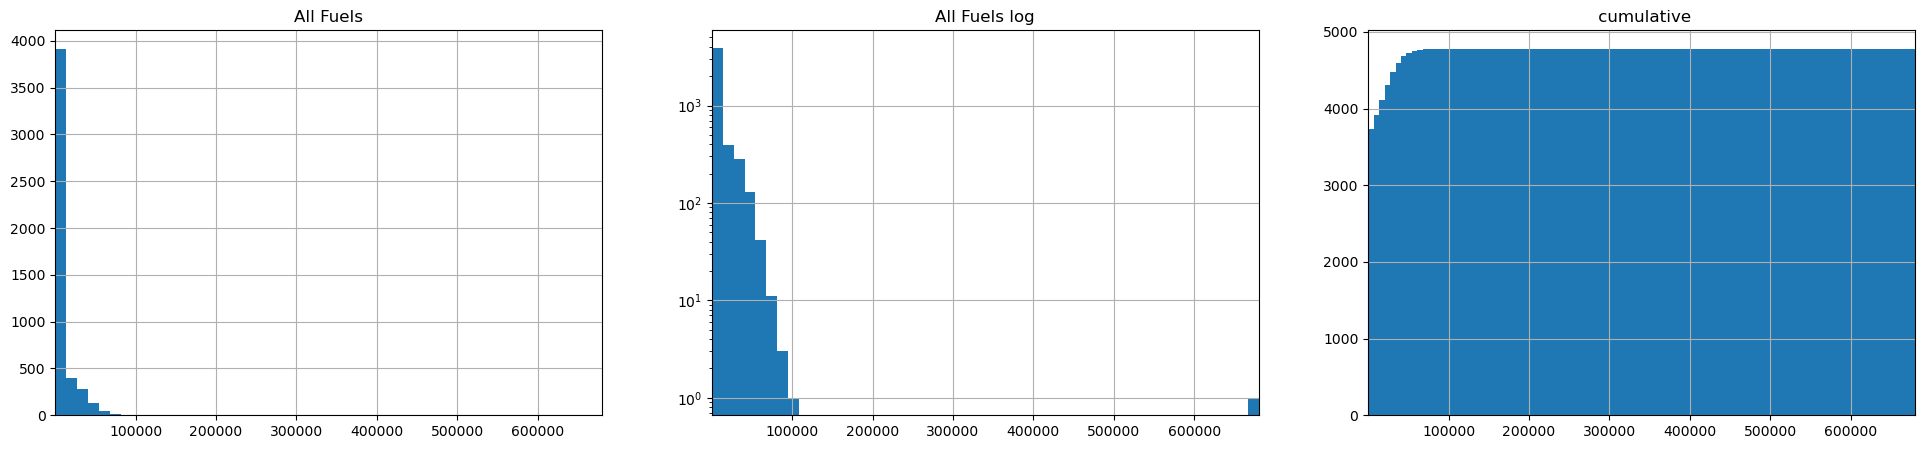

In [18]:
curr_df = _24
s = curr_df.groupby('zipcode').num_vehicles.sum()
fig, ax = plt.subplots(ncols=3, figsize=(24,5))
ax[0].hist(s, bins=50)
ax[0].set_title('All Fuels')
ax[0].grid()
ax[0].set_xlim(s.min(),s.max())

ax[1].hist(s, bins=50, log=True)
ax[1].set_title('All Fuels log')
ax[1].grid()
ax[1].set_xlim(s.min(),s.max())

ax[2].hist(s, bins=100, cumulative=True)
ax[2].set_title(" cumulative")
ax[2].grid()
ax[2].set_xlim(s.min(),s.max())


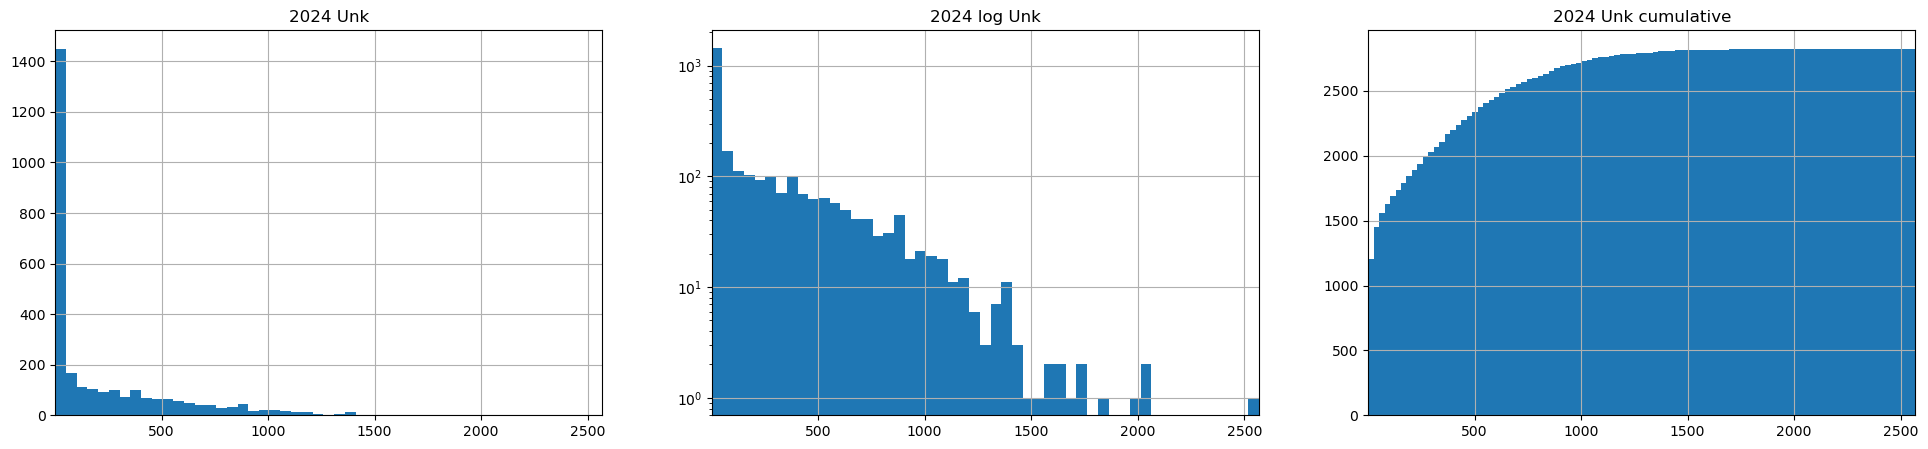

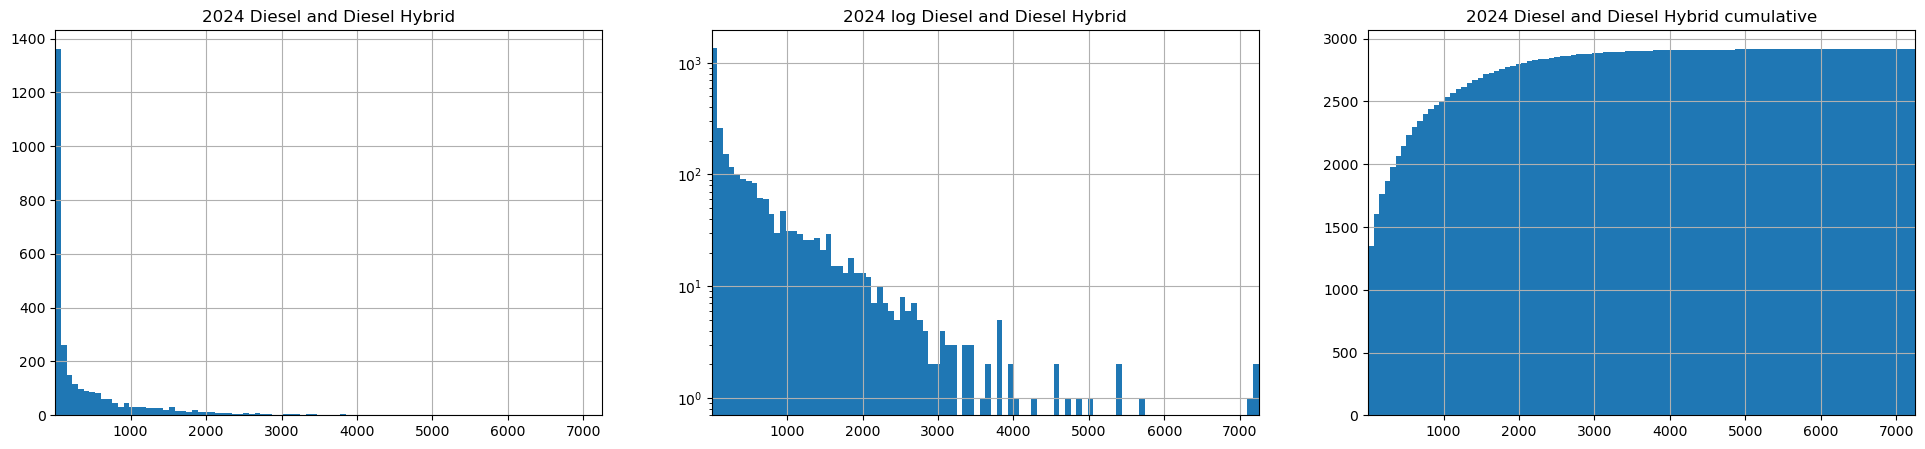

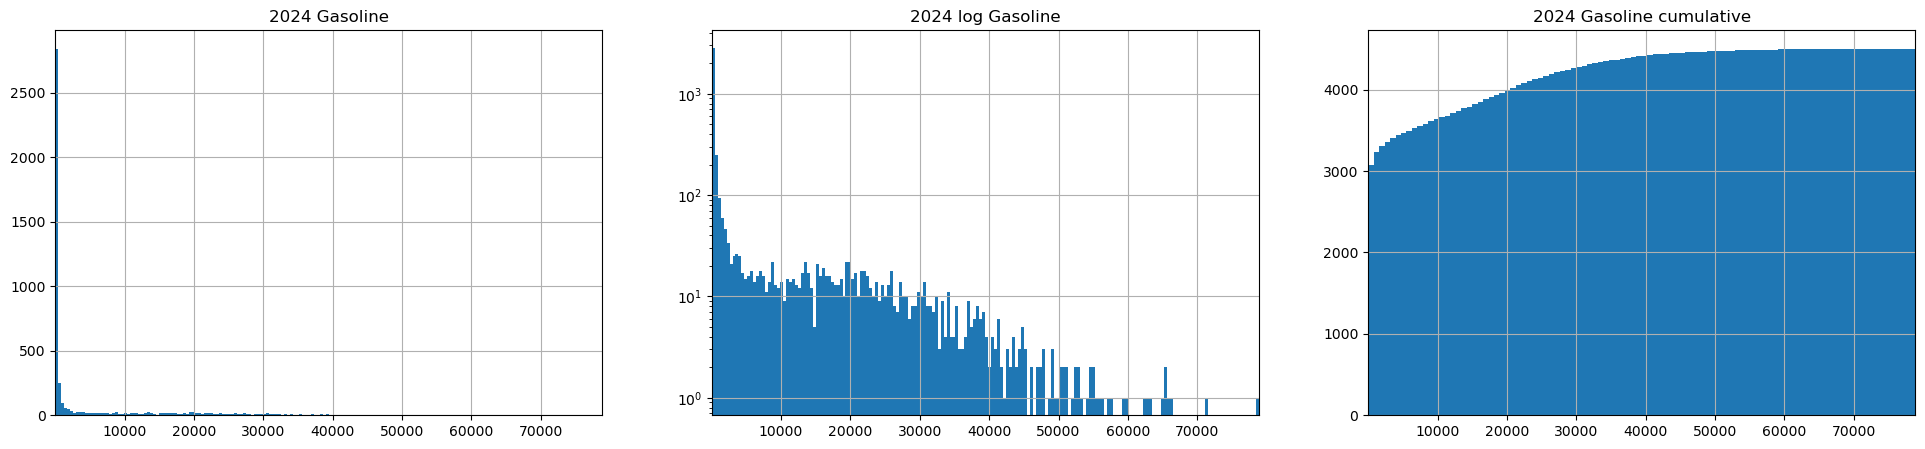

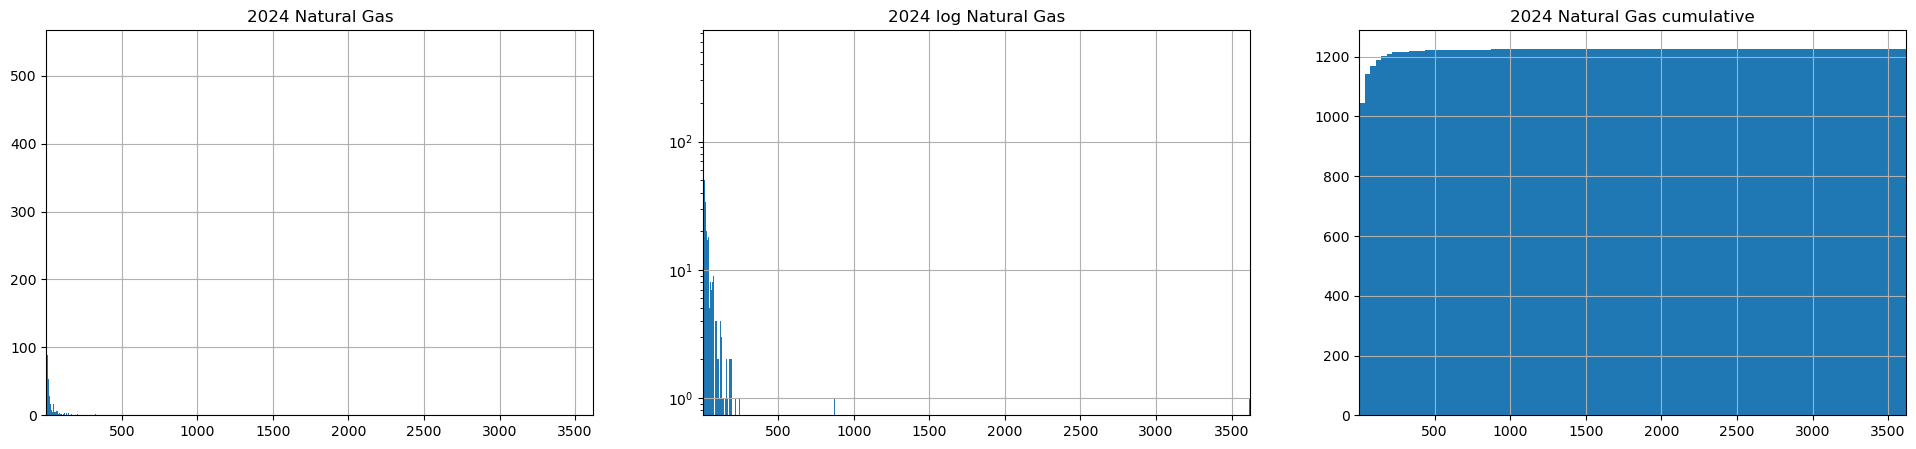

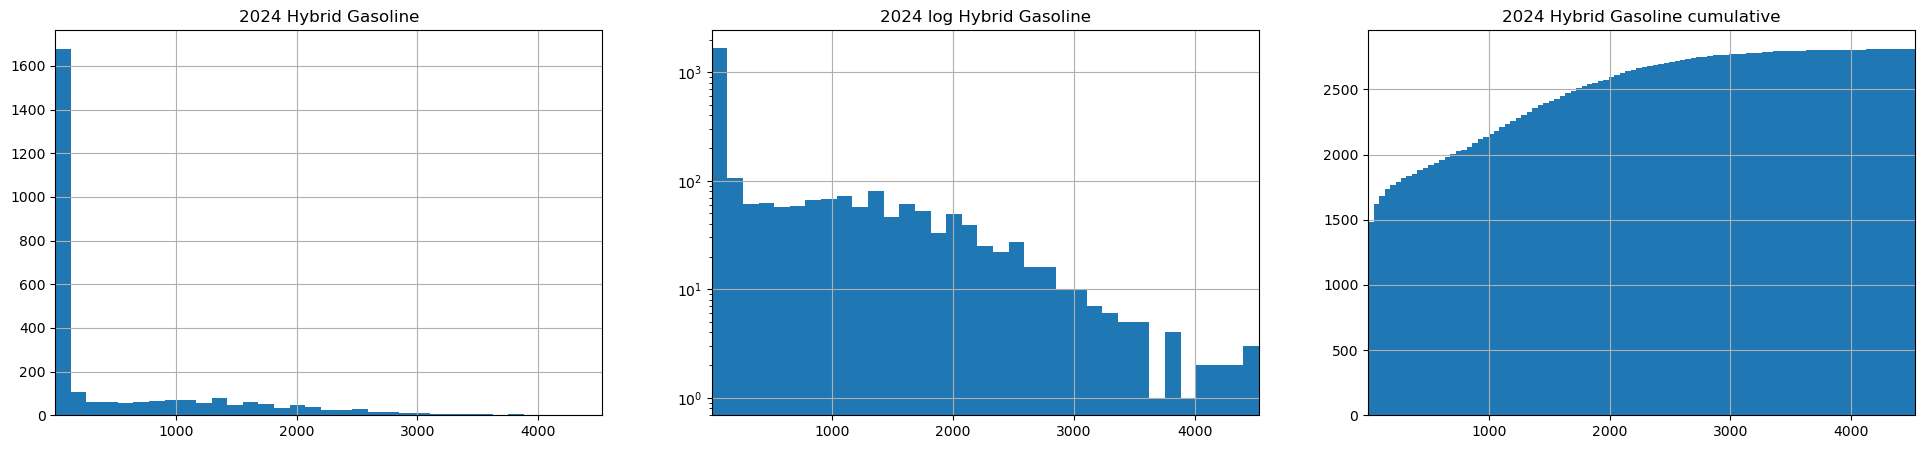

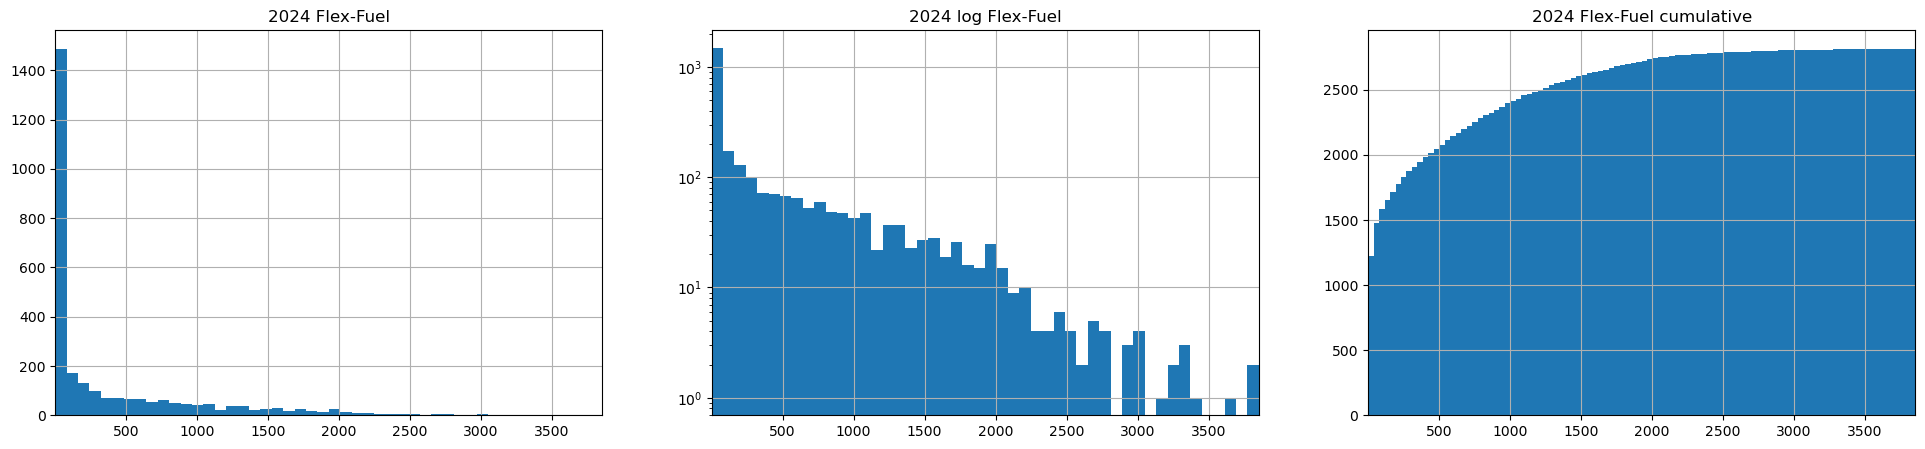

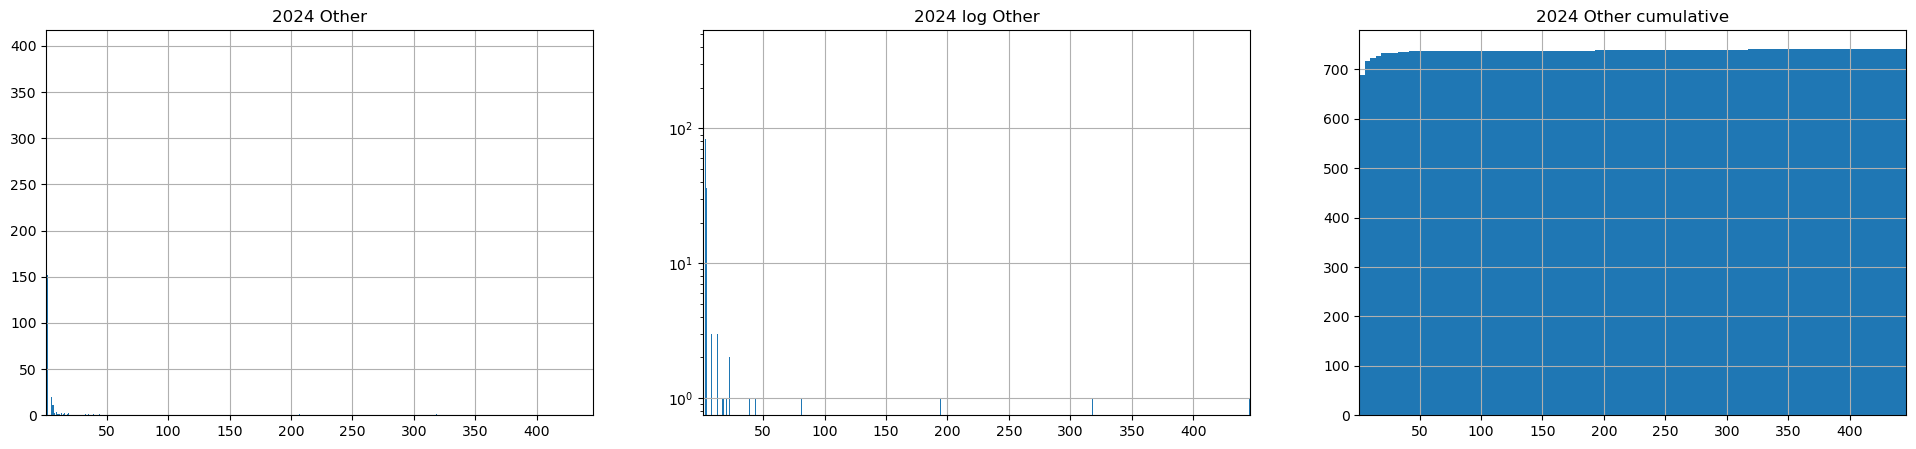

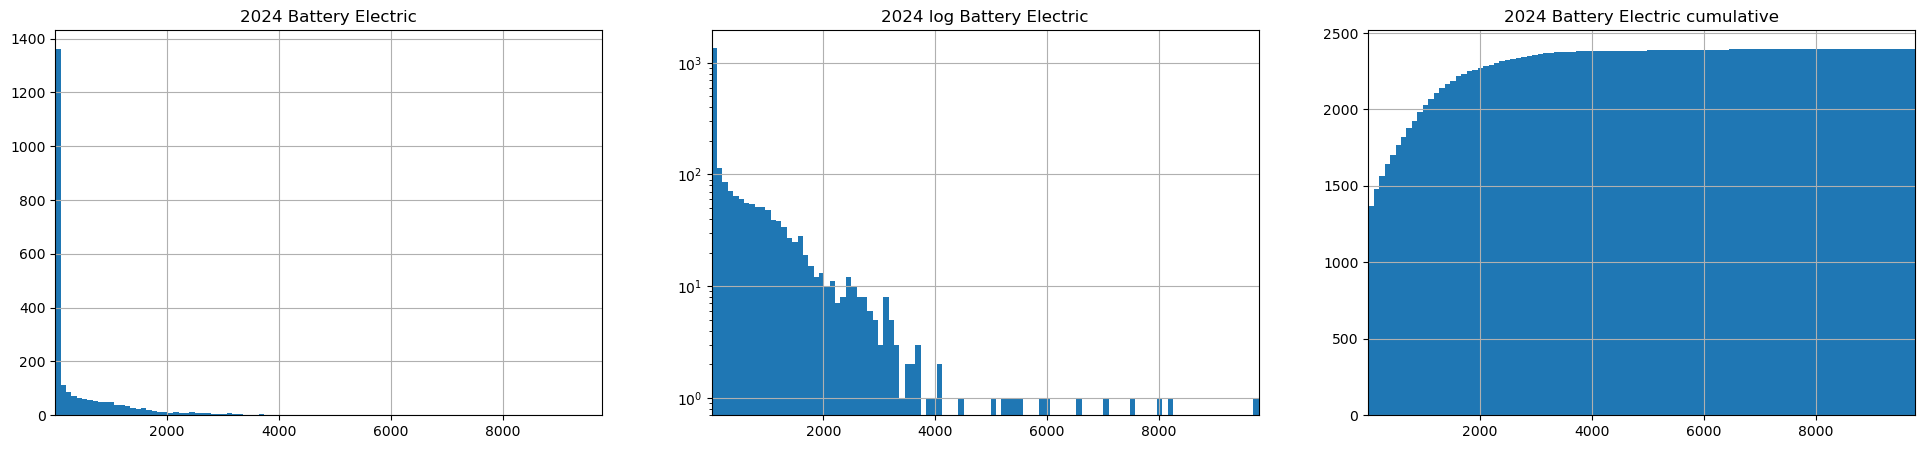

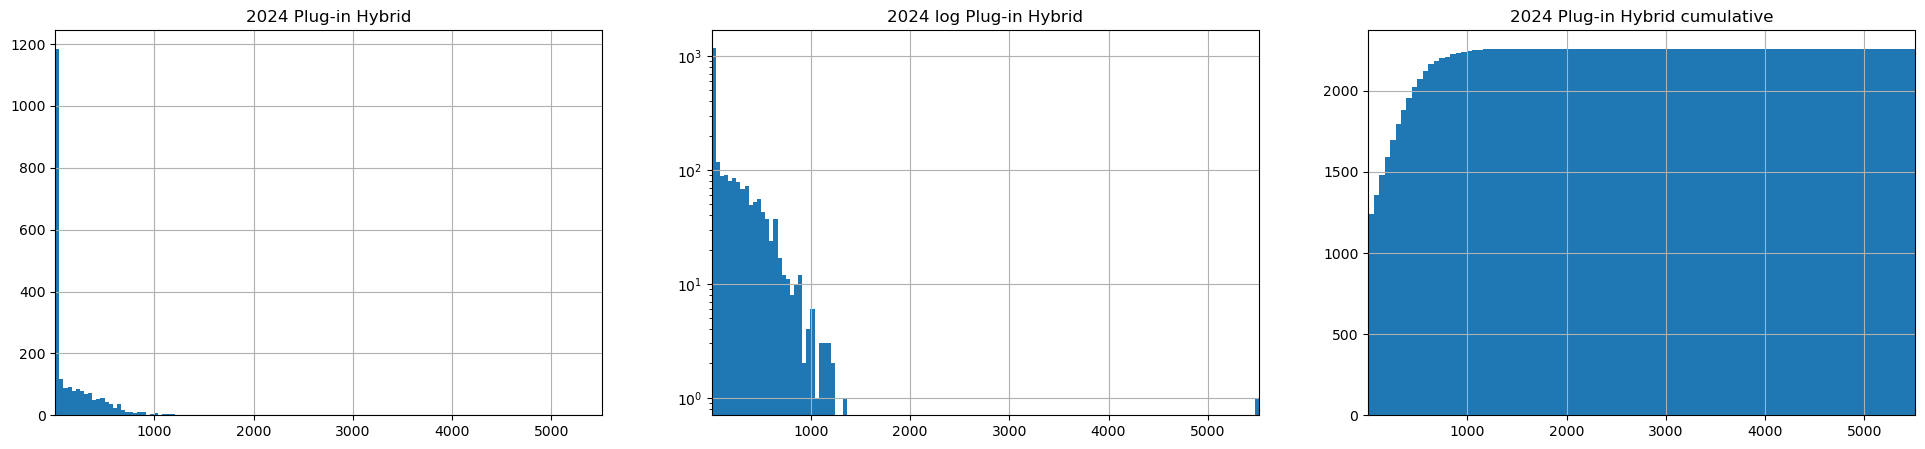

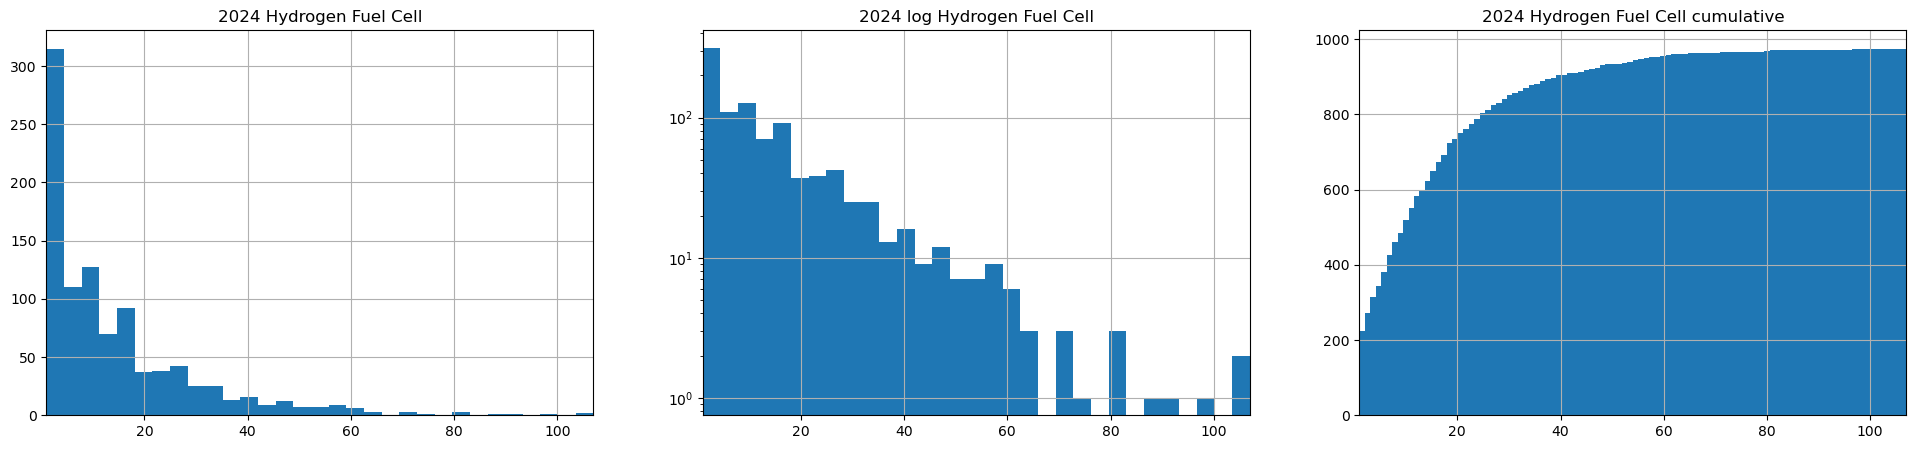

In [21]:

yr = 2024
for f in fuels:
        s = curr_df[(curr_df['fuel'] == f) & (curr_df['zipcode'] != 'OOS')].groupby('zipcode').num_vehicles.sum()
        fig, ax = plt.subplots(ncols=3, figsize=(24,5))
        ax[0].hist(s, bins='auto')
        ax[0].set_title(str(yr) +' '+ f)
        ax[0].grid()
        ax[0].set_xlim(s.min(),s.max())

        ax[1].hist(s, bins='auto', log=True)
        ax[1].set_title(str(yr) +' log '+ f)
        ax[1].grid()
        ax[1].set_xlim(s.min(),s.max())

        ax[2].hist(s, bins=100, cumulative=True)
        ax[2].set_title(str(yr) +' '+f + " cumulative")
        ax[2].grid()
        ax[2].set_xlim(s.min(),s.max())


        plt.show()
    

In [26]:
_19.head()

,year_id,date,zipcode,modelyr,fuel,make,duty,num_vehicles
0,1,2018-10-01,90000,2006,Gasoline,OTHER/UNK,Light,1
1,2,2018-10-01,90000,2014,Gasoline,OTHER/UNK,Light,1
2,3,2018-10-01,90000,2016,Gasoline,OTHER/UNK,Light,1
3,4,2018-10-01,90000,2017,Gasoline,OTHER/UNK,Light,1
4,5,2018-10-01,90000,<2006,Diesel and Diesel Hybrid,OTHER/UNK,Heavy,55


In [51]:
tsdf = pd.DataFrame(df.groupby(['fuel','date']).num_vehicles.sum()).reset_index()
ts_fuels = tsdf.fuel.unique()

In [55]:
ts_l = []
for fuel in ts_fuels:
    ts_l.append(tsdf[tsdf.fuel == fuel])
#ts_be = tsdf[tsdf.fuel == 'Battery Electric']
ts_l[0]

,fuel,date,num_vehicles
0,Battery Electric,2018-10-01,226614
1,Battery Electric,2020-01-01,306803
2,Battery Electric,2021-01-01,374865
3,Battery Electric,2022-01-01,526266
4,Battery Electric,2022-12-31,766670
5,Battery Electric,2023-12-31,1119289


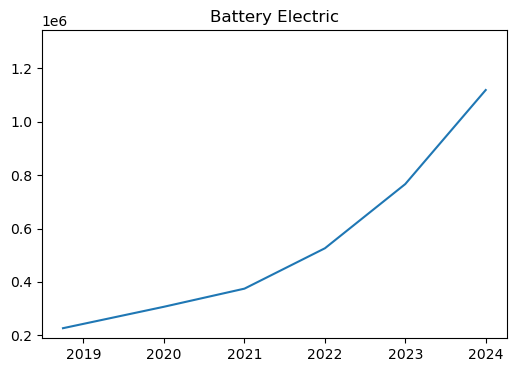

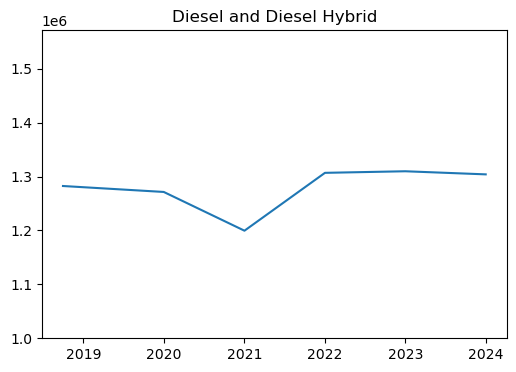

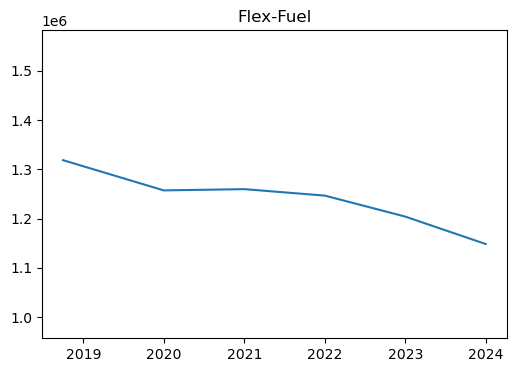

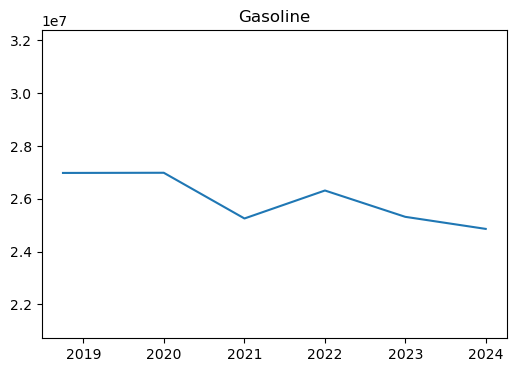

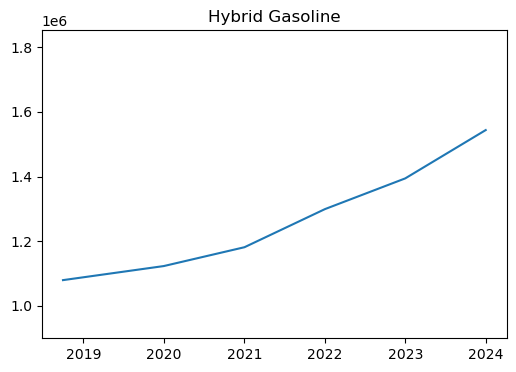

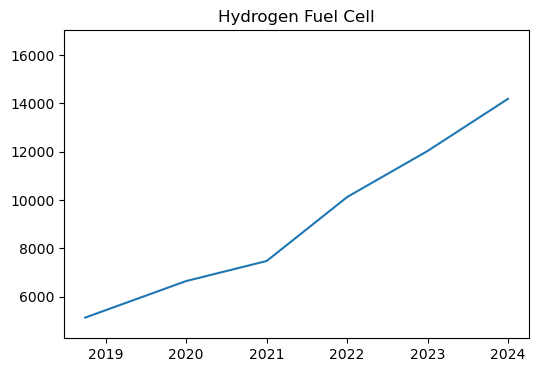

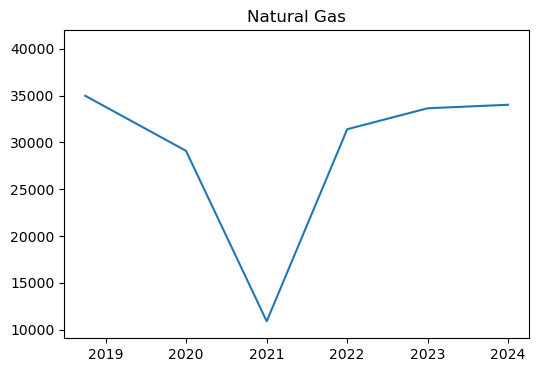

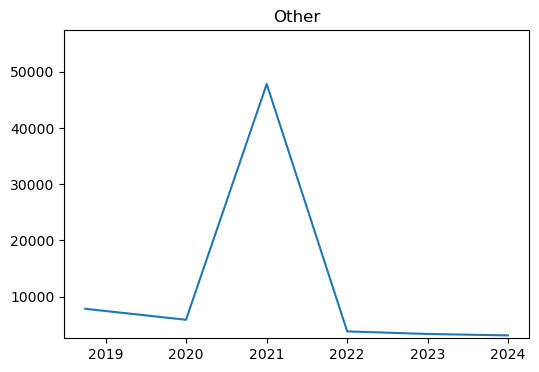

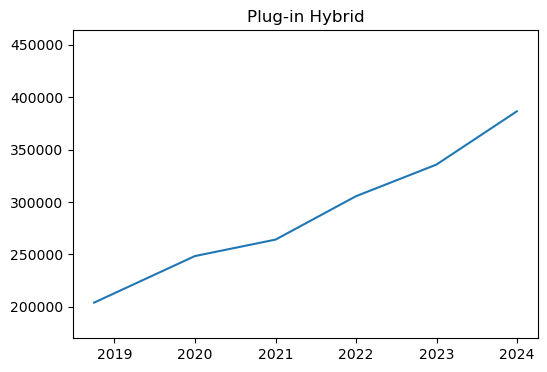

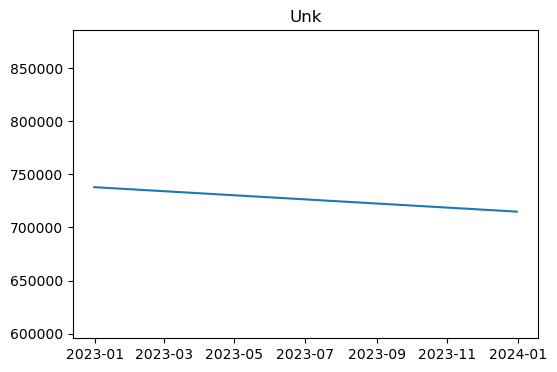

In [70]:

for fuel in ts_l:
    fig, ax = plt.subplots(ncols=1, figsize=(6,4))
    fuel_name = fuel.fuel.unique()[0]
    ax.set_ylim(fuel.num_vehicles.min()/1.2,fuel.num_vehicles.max()*1.2)
    ax.set_title(fuel_name)
    ax.plot(fuel['date'], fuel['num_vehicles'],label=fuel_name)
#ts_be.plot(ax=ax, kind='line', x='date', y='num_vehicles')